# Building an Agent with Generative Models and Tools

See this repo for a fuller implementation (ready to install and use!)
https://github.com/sinanuozdemir/squad-goals


## Imports

In [2]:
!pip install -q openai pinecone-client google-search-results alpaca-trade-api supabase diffusers accelerate

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.7/757.7 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from supabase import create_client, Client
from openai import OpenAI
from diffusers import StableDiffusionPipeline, DiffusionPipeline
from serpapi import GoogleSearch
from pydantic import BaseModel, Field
from google.colab import userdata
import datetime
import re
import os
import sys
import torch

from copy import copy
from functools import lru_cache
from io import StringIO
from typing import Dict, Optional, Any, List, Tuple
import PIL
import matplotlib.pyplot as plt


## Our First Tools - SERP & Python

In [4]:
class ToolInterface(BaseModel):
    name: str
    description: str

    def use(self, input_text: str) -> str:
        raise NotImplementedError("use() method not implemented")  # Must implement in subclass

class PythonREPLTool(ToolInterface):
    """A tool for running python code in a REPL."""

    globals: Optional[Dict] = Field(default_factory=dict, alias="_globals")
    locals: Optional[Dict] = Field(default_factory=dict, alias="_locals")

    name: str = "Python REPL"
    description: str = (
        "A Python shell. Use this to execute python commands. "
        "Input should be a valid python command. "
        "If you want to see the output of a value, you should print it out "
        "with `print(...)`. Include examples of using the code and print "
        "the output."
    )

    def _run(self, command: str) -> str:
        """Run command with own globals/locals and returns anything printed."""
        old_stdout = sys.stdout
        sys.stdout = mystdout = StringIO()
        try:
            exec(command, self.globals, self.locals)
            sys.stdout = old_stdout
            output = mystdout.getvalue()
        except Exception as e:
            sys.stdout = old_stdout
            output = str(e)
        return output.strip()

    def use(self, input_text: str) -> str:
        input_text = input_text.strip().replace("```python" , "")
        input_text = input_text.strip().strip("```")
        return self._run(input_text)


In [5]:
repl_tool = PythonREPLTool()
result = repl_tool.use('print(1+2)')
print(result)
assert result == "3"


3


In [6]:
@lru_cache(maxsize=None)
def search(query: str) -> str:
    params: dict = {
        "engine": "google",
        "google_domain": "google.com",
        "gl": "us",
        "hl": "en",
        "q": query,
        "api_key": userdata.get("SERP_API_KEY"),
    }

    search = GoogleSearch(params)
    res = search.get_dict()

    return _process_response(res)


def _process_response(res: dict) -> str:
    """Process response from SerpAPI."""
    if "error" in res.keys():
        raise ValueError(f"Got error from SerpAPI: {res['error']}")
    if "answer_box" in res.keys() and "answer" in res["answer_box"].keys():
        toret = res["answer_box"]["answer"]
    elif "answer_box" in res.keys() and "snippet" in res["answer_box"].keys():
        toret = res["answer_box"]["snippet"]
    elif (
        "answer_box" in res.keys()
        and "snippet_highlighted_words" in res["answer_box"].keys()
    ):
        toret = res["answer_box"]["snippet_highlighted_words"][0]
    elif (
        "sports_results" in res.keys()
        and "game_spotlight" in res["sports_results"].keys()
    ):
        toret = res["sports_results"]["game_spotlight"]
    elif (
        "knowledge_graph" in res.keys()
        and "description" in res["knowledge_graph"].keys()
    ):
        toret = res["knowledge_graph"]["description"]
    elif "snippet" in res["organic_results"][0].keys():
        toret = res["organic_results"][0]["snippet"]

    else:
        toret = "No good search result found"
    return toret


class SerpAPITool(ToolInterface):
    """Tool for Google search results."""

    name: str = "Google Search"
    description: str = "Get specific information from a search query. Input should be a question like 'How to add number in Clojure?'. Result will be the answer to the question."

    def use(self, input_text: str) -> str:
        return search(input_text)


In [7]:
serp_tool = SerpAPITool()
serp_tool.use("Who is the current Ravens QB?")

'The Baltimore Ravens are a professional American football team based in Baltimore. The Ravens compete in the National Football League as a member of the American Football Conference North division. The team plays its home games at M&T Bank Stadium and is headquartered in Owings Mills, Maryland.'

In [8]:
""

''

## OpenAI LLM

In [17]:
client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))
url: str = userdata.get('SUPABASE_URL')
key: str = userdata.get('SUPABASE_API_KEY')
supabase: Client = create_client(url, key)

class ChatLLM(BaseModel):
    model: str = 'gpt-4o'
    temperature: float = 0.0

    def generate(self, prompt: str, stop: List[str] = None):
        response = client.chat.completions.create(
            model=self.model,
            messages=[{"role": "user", "content": prompt}],
            temperature=self.temperature,
            stop=stop
        )
        supabase.table('cost_projecting').insert({
            'prompt': prompt,
            'response': response.choices[0].message.content,
            'input_tokens': response.usage.prompt_tokens,
            'output_tokens': response.usage.completion_tokens,
            'model': self.model,
            'inference_params' : {
                'temperature': self.temperature,
                'stop': stop
            },
            'is_openai': True,
            'app': 'AGENT'
        }).execute()
        return response.choices[0].message.content

In [18]:
llm = ChatLLM()
result = llm.generate(prompt='Who is the president of Turkey?')
print(result)

As of my last update, the president of Turkey is Recep Tayyip Erdoğan. He has been in office since August 28, 2014. However, please verify with a current source, as political positions can change.


In [19]:
FINAL_ANSWER_TOKEN = "Assistant Response:"
OBSERVATION_TOKEN = "Observation:"
THOUGHT_TOKEN = "Thought:"
PROMPT_TEMPLATE = """Today is {today} and you can use tools to get new information. Respond to the user's input as best as you can using the following tools:

{tool_description}

You must follow the following format for every single turn of the conversation:

User Input: the input question you must answer
Thought: comment on what you want to do next.
Action: the action to take, exactly one element of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
Thought: Now comment on what you want to do next.
Action: the next action to take, exactly one element of [{tool_names}]
Action Input: the input to the next action
Observation: the result of the next action
Thought: Now comment on what you want to do next.
... (this Thought/Action/Action Input/Observation repeats until you are sure of the answer)
Assistant Thought: I have enough information to respond to the user's input.
Assistant Response: your final answer to the original input question
User Input: the input question you must answer
Thought: comment on what you want to do next.
Action: the next action to take, exactly one element of [{tool_names}]
Action Input: the input to the next action
Observation: the result of the next action
... (this Thought/Action/Action Input/Observation repeats until you are sure of the answer)
Assistant Thought: I have enough information to respond to the user's input.
Assistant Response: your final answer to the original input question

You must end every round with "Assistant Thought:" and "Assistant Response:"

Begin:

{previous_responses}
"""

class Agent(BaseModel):
    llm: ChatLLM
    tools: List
    prompt_template: str = PROMPT_TEMPLATE
    max_loops: int = 5
    # The stop pattern is used, so the LLM does not hallucinate until the end
    stop_pattern: List[str] = [f'\n{OBSERVATION_TOKEN}', f'\n\t{OBSERVATION_TOKEN}']
    human_responses: List[str] = []
    ai_responses: List[str] = []
    pretty_responses: List[str] = []
    verbose: bool = False

    @property
    def tool_description(self) -> str:
        return "\n".join([f"{tool.name}: {tool.description}" for tool in self.tools])

    @property
    def tool_names(self) -> str:
        return ", ".join([tool.name for tool in self.tools])

    @property
    def tool_by_names(self) -> Dict[str, ToolInterface]:
        return {tool.name: tool for tool in self.tools}

    def run(self, question: str):
        self.ai_responses.append(f'User Input: {question}')
        self.human_responses.append(question)
        previous_responses = copy(self.ai_responses)
        num_loops = 0
        prompt = self.prompt_template.format(
                today = datetime.date.today(),
                tool_description=self.tool_description,
                tool_names=self.tool_names,
                question=question,
                previous_responses='{previous_responses}'
        )
        if self.verbose:
            print('------')
            print(prompt.format(previous_responses=''))
            print('------')
        while num_loops < self.max_loops:
            num_loops += 1
            curr_prompt = prompt.format(previous_responses='\n'.join(previous_responses))
            generated, tool, tool_input = self.decide_next_action(curr_prompt)
            if self.verbose:
                print('------')
                print('CURR PROMPT')
                print('------')
                print(curr_prompt)
                print('------')
                print('------')
                print('RAW GENERATED')
                print('------')
                print(generated)
                print('------')
            if tool == 'Assistant Response':
                if self.verbose:
                    print('------')
                    print('FINAL PROMPT')
                    print('------')
                    print(curr_prompt)
                    print('------')
                self.ai_responses.append(f'Assistant Response: {tool_input}')
                return tool_input
            if tool not in self.tool_by_names:
                raise ValueError(f"Unknown tool: {tool}")
            if self.verbose:
                print('tool_input', tool_input)
            tool_result = self.tool_by_names[tool].use(tool_input)
            if type(tool_result) == PIL.Image.Image:
                plt.imshow(tool_result)
                plt.show()
            generated += f"\n{OBSERVATION_TOKEN} {tool_result}\n"
            self.ai_responses.append(generated.strip())
            if self.verbose:
                print('------')
                print('PARSED GENERATED')
                print('------')
                print(generated)
                print('------')
            previous_responses.append(generated)

    def decide_next_action(self, prompt: str) -> str:
        generated = self.llm.generate(prompt, stop=self.stop_pattern)

        tool, tool_input = self._parse(generated)
        return generated, tool, tool_input

    def _parse(self, generated: str) -> Tuple[str, str]:
        if FINAL_ANSWER_TOKEN in generated:
            if self.verbose:
                print('------')
                print('FINAL ANSWER')
                print('------')
                print(generated)
                print('------')
            final_answer = generated.split(FINAL_ANSWER_TOKEN)[-1].strip()
            self.pretty_responses.append(final_answer)
            return "Assistant Response", final_answer
        regex = r"Action: [\[]?(.*?)[\]]?[\n]*Action Input:[\s]*(.*)"
        match = re.search(regex, generated, re.DOTALL)
        if not match:
            raise ValueError(f"Output of LLM is not parsable for next tool use: `{generated}`")
        tool = match.group(1).strip()
        tool_input = match.group(2)
        return tool, tool_input.strip(" ").strip('"')



In [20]:
agent = Agent(llm=ChatLLM(), tools=[PythonREPLTool(), SerpAPITool()], verbose=True)
result = agent.run("please write me a function to take in a number and return 2 times it")

print(f"Final answer is {result}")

------
Today is 2025-06-27 and you can use tools to get new information. Respond to the user's input as best as you can using the following tools:

Python REPL: A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`. Include examples of using the code and print the output.
Google Search: Get specific information from a search query. Input should be a question like 'How to add number in Clojure?'. Result will be the answer to the question.

You must follow the following format for every single turn of the conversation:

User Input: the input question you must answer
Thought: comment on what you want to do next.
Action: the action to take, exactly one element of [Python REPL, Google Search]
Action Input: the input to the action
Observation: the result of the action
Thought: Now comment on what you want to do next.
Action: the next action to take, exactly one element o

In [21]:
for a in agent.ai_responses:
    print(a)
    print('------')

User Input: please write me a function to take in a number and return 2 times it
------
Thought: I will write a simple Python function that takes a number as input and returns twice that number.
Action: Python REPL
Action Input: 
```python
def double_number(n):
    return 2 * n

# Example usage
print(double_number(5))  # Should return 10
print(double_number(0))  # Should return 0
print(double_number(-3)) # Should return -6
```
Observation: 10
0
-6
------
Assistant Response: Here is a Python function that takes a number as input and returns twice that number:

```python
def double_number(n):
    return 2 * n

# Example usage
print(double_number(5))  # Should return 10
print(double_number(0))  # Should return 0
print(double_number(-3)) # Should return -6
```

You can use this function by calling `double_number()` with the desired number as the argument.
------


In [22]:
agent = Agent(llm=ChatLLM(), tools=[PythonREPLTool(), SerpAPITool()])
result = agent.run("How many people are allowed on the baseball field during play?")

print(f"Final answer is {result}")

for a in agent.ai_responses:
    print(a)
    print('---')

Final answer is During a baseball game, there are typically nine defensive players on the field. Additionally, there can be up to four offensive players on the field at the same time: the batter and up to three base runners. Therefore, a maximum of 13 players can be on the field during play.
User Input: How many people are allowed on the baseball field during play?
---
Thought: I need to find out the number of people typically allowed on a baseball field during play. This information can be found through a quick search.
Action: Google Search
Action Input: How many people are allowed on the baseball field during play?
Observation: There are nine defensive players on the field during play. There can be as many as four offensive players on the field (the batter plus up to three base ...
---
Assistant Response: During a baseball game, there are typically nine defensive players on the field. Additionally, there can be up to four offensive players on the field at the same time: the batter an

## Adding conversational tools

Making our agent more efficient by letting it speak without the need of strict tools

In [ ]:
agent = Agent(llm=ChatLLM(), tools=[PythonREPLTool(), SerpAPITool()])

result = agent.run("What state is San Francisco in?") # probably didn't need to look that up..

for a in agent.ai_responses:
    print(a)
    print('---')

User Input: What state is San Francisco in?
---
Thought: I need to find out which state San Francisco is located in.
Action: Google Search
Action Input: What state is San Francisco in?
Observation: San Francisco, officially the City and County of San Francisco, is a commercial, financial, and cultural center within Northern California. With a population of 808,988 residents as of 2023, San Francisco is the fourth-most populous city in the U.S. state of California behind Los Angeles, San Diego, and San Jose.
---
Assistant Response: San Francisco is located in the state of California.
---


In [ ]:
class SimplyRespond(ToolInterface):  # sometimes referred to as "directly answer"

    name: str = 'Simply Respond'
    description: str = 'Choose this option if the user is giving a pleasantry '
    'or if the answer is very simple knowledge. The action input is nothing.'

    def use(self, input_text: str) -> str:
        return input_text

class Inquire(ToolInterface):

    name: str = 'Inquire for more Information'
    description: str = 'Choose this option if further information is required '
    'to respond to the user. The action input is a question to ask the user'

    def use(self, input_text: str) -> str:
        return input_text

In [ ]:
agent = Agent(llm=ChatLLM(), tools=[PythonREPLTool(), SerpAPITool(), SimplyRespond(), Inquire()])

result = agent.run("What state is San Francisco in?") # probably Didn't look anything up

for a in agent.ai_responses:
    print(a)
    print('---')

User Input: What state is San Francisco in?
---
Thought: I know that San Francisco is a well-known city, and I can provide the information directly.
Action: Simply Respond
Action Input: None
Observation: None
---
Assistant Response: San Francisco is in the state of California.
---


In [ ]:
agent = Agent(llm=ChatLLM(), tools=[PythonREPLTool(), SerpAPITool(), SimplyRespond(), Inquire()])

result = agent.run("Hey") # didn't need to look that up..

for a in agent.ai_responses:
    print(a)
    print('---')

User Input: Hey
---
Thought: The user is greeting me.
Action: Simply Respond
Action Input: Hello! How can I assist you today?
Observation: Hello! How can I assist you today?
---
Assistant Response: Hello! How can I assist you today?
---


In [ ]:
agent = Agent(llm=ChatLLM(), tools=[PythonREPLTool(), SerpAPITool(), SimplyRespond(), Inquire()])

result = agent.run("What state is this city in?") # inquires for more information

for a in agent.ai_responses:
    print(a)
    print('---')

User Input: What state is this city in?
---
Thought: The user has not specified which city they are referring to. I need to ask for more information to provide an accurate response.
Action: Inquire for more Information
Action Input: Could you please specify the name of the city you are asking about?
Observation: Could you please specify the name of the city you are asking about?
---
Assistant Response: Could you please specify the name of the city you are asking about?
---


In [ ]:
agent = Agent(llm=ChatLLM(), tools=[SimplyRespond(), PythonREPLTool(), SerpAPITool(),  Inquire()])
agent.run("What is 1064 + the current price of the cryptocurrency in USD?")  # inquiring

'Could you please specify which cryptocurrency you are referring to? For example, Bitcoin, Ethereum, etc.'

In [ ]:
agent.run("Sorry, Etheruem")

'The sum of 1064 and the current price of Ethereum in USD is 4160.57.'

In [ ]:
agent.run("one more thing, what day of the week is tomorrow?")

'Tomorrow, November 20, 2024, will be a Wednesday.'

In [ ]:
agent.run("I forgot to ask, what is the reversed name of the current executive director of common crawl?")

'The reversed name of the current executive director of Common Crawl, Rich Skrenta, is "atnerkS hciR".'

In [ ]:
for h, a in list(zip(agent.human_responses, agent.pretty_responses)):
    print(f"{h} -> \n\t{a}\n")

What is 1064 + the current price of the cryptocurrency in USD? -> 
	Could you please specify which cryptocurrency you are referring to? For example, Bitcoin, Ethereum, etc.

Sorry, Etheruem -> 
	The sum of 1064 and the current price of Ethereum in USD is 4160.57.

one more thing, what day of the week is tomorrow? -> 
	Tomorrow, November 20, 2024, will be a Wednesday.

I forgot to ask, what is the reversed name of the current executive director of common crawl? -> 
	The reversed name of the current executive director of Common Crawl, Rich Skrenta, is "atnerkS hciR".



In [ ]:
for a in agent.ai_responses:
    print(a)
    print('---')

User Input: What is 1064 + the current price of the cryptocurrency in USD?
---
Thought: I need to find the current price of a specific cryptocurrency in USD to perform the calculation. However, the user hasn't specified which cryptocurrency they are interested in. 
Action: Inquire for more Information
Action Input: Could you please specify which cryptocurrency you are referring to? For example, Bitcoin, Ethereum, etc.
Observation: Could you please specify which cryptocurrency you are referring to? For example, Bitcoin, Ethereum, etc.
---
Assistant Response: Could you please specify which cryptocurrency you are referring to? For example, Bitcoin, Ethereum, etc.
---
User Input: Sorry, Etheruem
---
Thought: Now that I know the user is interested in the current price of Ethereum, I will perform a Google Search to find the current price of Ethereum in USD.
Action: Google Search
Action Input: What is the current price of Ethereum in USD?
Observation: The live Ethereum price today is $3096.57

## Stock Price Tool

A completely custom API tool to look up a paper trading account using https://alpaca.markets

In [ ]:
from typing import Optional, Dict
from pydantic import BaseModel
import alpaca_trade_api as tradeapi

class CheckStockBalance(ToolInterface):
    api_key: str
    api_secret: str
    base_url: str
    api_version: str = 'v2'
    """A tool for checking the current stock wallet balance using Alpaca API."""

    name: str = "Check Stock Balance"
    description: str = (
        "A tool that uses the Alpaca Trade API to retrieve the current wallet balance, "
        "allowing users to check their available cash and stock positions. "
        "The action input to this tool is exactly one of the following commands: "
        "[get_balance]"

    )

    def get_account_balance(self) -> Dict[str, float]:
        """Retrieves the current wallet balance including cash and account value."""
        alpaca_api = tradeapi.REST(
            self.api_key, self.api_secret, self.base_url,
            api_version=self.api_version)
        account = alpaca_api.get_account()
        return {
            "cash": float(account.cash),
            "portfolio_value": float(account.portfolio_value)
        }

    def use(self, command: str) -> str:
        """Run a command to get the account balance."""
        if command == "get_balance":
            balance = self.get_account_balance()
            return f"Cash: ${balance['cash']}, Portfolio Value: ${balance['portfolio_value']}"
        else:
            return "Unknown command. Please use 'get_balance' to check your wallet balance."

check_stock_balance = CheckStockBalance(
    api_key=userdata.get('PAPER_ALPACA_API_KEY'),
    api_secret=userdata.get('PAPER_ALPACA_API_SECRET'),
    base_url='https://paper-api.alpaca.markets'
    )

check_stock_balance.use('get_balance')

'Cash: $4996.53, Portfolio Value: $4996.53'

In [ ]:
sawyer = Agent(llm=ChatLLM(), tools=[
    check_stock_balance,
    PythonREPLTool(),
    SerpAPITool(),
    SimplyRespond(),
    Inquire()
])

def chat_with(agent):
# Chat loop
    while True:
        user_input = input("You (exit to quit): ")
        if user_input.lower() in ["exit", "quit"]:
            break
        response = agent.run(user_input)
        print("Agent:", response)

    # After exiting the loop, print all AI responses
    print("\nAI Responses:")
    for response in agent.ai_responses:
        print(response)

chat_with(agent := sawyer)

You (exit to quit): what's my current balance?
Agent: Your current balance is $4996.53, which includes both your cash and portfolio value.
You (exit to quit): what's the square root of that?
Agent: The square root of your current balance, $4996.53, is approximately 70.69.
You (exit to quit): exit

AI Responses:
User Input: what's my current balance?
Thought: The user wants to know their current stock balance. I will use the Check Stock Balance tool to retrieve this information.
Action: Check Stock Balance
Action Input: get_balance
Observation: Cash: $4996.53, Portfolio Value: $4996.53
Assistant Response: Your current balance is $4996.53, which includes both your cash and portfolio value.
User Input: what's the square root of that?
Thought: I need to calculate the square root of the user's current balance, which is $4996.53. I will use the Python REPL to perform this calculation.
Action: Python REPL
Action Input: 
```python
import math

balance = 4996.53
square_root = math.sqrt(balance)

## Image Generation Tool

Using Stable Diffusion to let our agent generate images

In [1]:
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to("cuda")

class StableDiffusionTool(ToolInterface):
    """A tool for generating images"""
    name: str = "Stable Diffusion"
    description: str = (
        "A tool for performing image generation using stable diffusion. "
        "The action input to this tool is a prompt to create an image "
        "like 'A photo of a cat on a white background' or 'A surrealist painting of a sunset'."
    )

    def use(self, prompt: str) -> str:
        """Run the stable diffusion tool."""
        return pipe(prompt).images[0]


NameError: name 'StableDiffusionPipeline' is not defined

  0%|          | 0/50 [00:00<?, ?it/s]

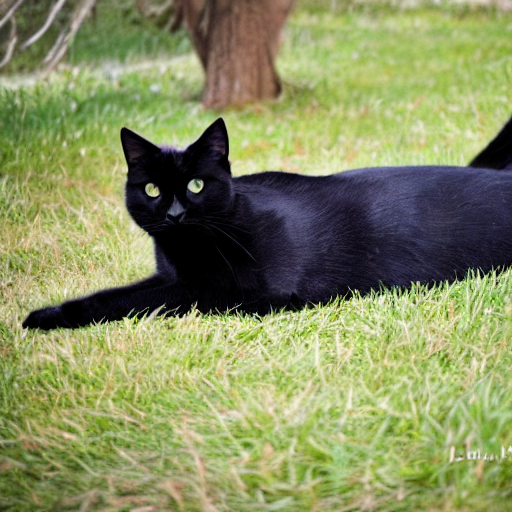

In [ ]:
stable_diffusion_tool = StableDiffusionTool()
stable_diffusion_tool.use('A photo of a black cat lounging around')

You (exit to quit): I need a picture of a black cat


  0%|          | 0/50 [00:00<?, ?it/s]

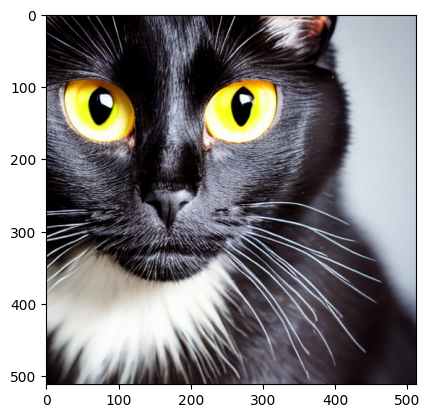

Agent: Here is the image of a black cat that you requested.
You (exit to quit): can you make it in paris?


  0%|          | 0/50 [00:00<?, ?it/s]

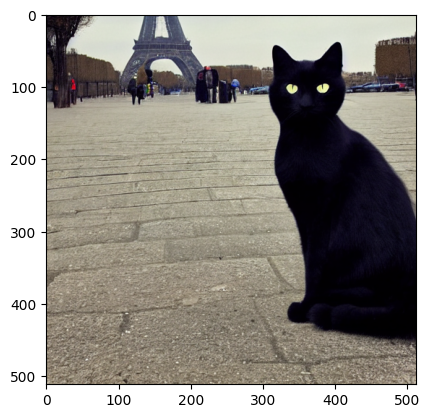

Agent: Here is the image of a black cat in Paris with the Eiffel Tower in the background that you requested.
You (exit to quit): what's my stock balance?
Agent: Your current cash balance is $4996.53, and your total portfolio value is also $4996.53.
You (exit to quit): exit

AI Responses:
User Input: I need a picture of a black cat
Thought: I will use the Stable Diffusion tool to generate an image of a black cat.
Action: Stable Diffusion
Action Input: A photo of a black cat on a white background
Observation: <PIL.Image.Image image mode=RGB size=512x512 at 0x784C7FE13BB0>
Assistant Response: Here is the image of a black cat that you requested.
User Input: can you make it in paris?
Thought: I will use the Stable Diffusion tool to generate an image of a black cat in Paris.
Action: Stable Diffusion
Action Input: A photo of a black cat in Paris, with the Eiffel Tower in the background
Observation: <PIL.Image.Image image mode=RGB size=512x512 at 0x784C7DDC9FF0>
Assistant Response: Here is the

In [ ]:
sawyer = Agent(llm=ChatLLM(), tools=[
    PythonREPLTool(),
    SerpAPITool(),
    SimplyRespond(),
    Inquire(),
    StableDiffusionTool(),
    check_stock_balance
])

chat_with(sawyer)

## RAG using a lookup API

Check out https://github.com/sinanuozdemir/oreilly-retrieval-augmented-gen-ai for the code for my RAG video/course


In [ ]:
from pinecone import Pinecone

class LookupTool(ToolInterface):
    """A tool for performing semantic searches using Pinecone and OpenAI embeddings."""

    # Pinecone setup
    pinecone_key: str = userdata.get('PINECONE_API_KEY')
    INDEX_NAME: str = 'semantic-search-rag'
    ENGINE: str = 'text-embedding-3-small'
    NAMESPACE: str = 'default'

    name: str = "Semantic Search Tool"
    description: str = (
        "A tool for performing information lookup. Look something up if you "
        "are being asked about a fact. Even if the retrieved information is "
        "irrelevant, mention that in the thought and answer the question."
    )

    def __init__(self, **data):
        super().__init__(**data)

    def get_embeddings(self, texts, engine=ENGINE):
        response = OpenAI(api_key=userdata.get('OPENAI_API_KEY')).embeddings.create(
            input=texts,
            model=engine
        )
        return [d.embedding for d in list(response.data)]

    def get_embedding(self, text, engine=ENGINE):
        return self.get_embeddings([text], engine)[0]

    def query_from_pinecone(self, query, top_k=3, include_metadata=True):
        # get embedding from THE SAME embedder as the documents
        query_embedding = self.get_embedding(query, engine=self.ENGINE)
        index = Pinecone(api_key=userdata.get('PINECONE_API_KEY')).Index(name=self.INDEX_NAME)

        return index.query(
          vector=query_embedding,
          top_k=top_k,
          namespace=self.NAMESPACE,
          include_metadata=include_metadata   # gets the metadata (dates, text, etc)
        ).get('matches')[0]['metadata']['text']

    def use(self, query):
        return self.query_from_pinecone(query)


In [ ]:
l = LookupTool()
l.use('I lost my medicare card')

'Youre offline. This is a read only version of the page. Upcoming account changes Switch to Login.gov or ID.me for . Upcoming account changes Switch to Login.gov or ID.me for . Social Security Search Español Frequently Asked Questions FAQ Home Topics KA01735 How do I get a replacement Medicare card? If your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov. You can an official copy of your card from your online Medicare account or call 1800MEDICARE to order a replacement card to be sent in the mail. Footer ?'

In [ ]:
agent = Agent(llm=ChatLLM(), tools=[PythonREPLTool(), LookupTool()])
result = agent.run("What is the hash of the number I need to call to replace my medicare card")

print(f"Final answer is {result}")

Final answer is The SHA-256 hash of the contact number 1-800-MEDICARE (18006334227) is `f769a496dccd9b19b01bcd62facb6b32c1bebea34ef36e903708da5ace01dcb2`.


In [ ]:
for a in agent.ai_responses:
    print(a)
    print('---')

User Input: What is the hash of the number I need to call to replace my medicare card
---
Thought: I need to find the contact number for replacing a Medicare card and then compute its hash. First, I will look up the contact number using the Semantic Search Tool.
Action: Semantic Search Tool
Action Input: "contact number to replace Medicare card"
Observation: Youre offline. This is a read only version of the page. Upcoming account changes Switch to Login.gov or ID.me for . Upcoming account changes Switch to Login.gov or ID.me for . Social Security Search Español Frequently Asked Questions FAQ Home Topics KA01735 How do I get a replacement Medicare card? If your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov. You can an official copy of your card from your online Medicare account or call 1800MEDICARE to order a replacement card to be sent in the mail. Footer ?
---
Action: Python REPL
Action Input: 
```python
import hashlib

# The contac

## Basic Cost Projecting

Looking at the input/output tokens in our data warehouse (Supabase)

In [ ]:
import pandas as pd

response = supabase.table('cost_projecting').select("*").eq('app', 'AGENT').execute()
completions_df = pd.DataFrame(response.data)
completions_df.index = pd.to_datetime(completions_df['created_at'])

completions_df.head()

,id,created_at,prompt,response,model,is_openai,input_tokens,output_tokens,inference_params,app
created_at,,,,,,,,,,
2024-03-19 00:11:59.767265+00:00,11,2024-03-19T00:11:59.767265+00:00,Today is 2024-03-19 and you can use tools to g...,Thought: I can use Python to search for inform...,gpt-3.5-turbo,True,263,26,"{'stop': [' Observation:', ' Observation:'], ...",AGENT
2024-03-19 00:12:00.743284+00:00,12,2024-03-19T00:12:00.743284+00:00,Today is 2024-03-19 and you can use tools to g...,Thought: It seems like the Wikipedia module is...,gpt-3.5-turbo,True,300,48,"{'stop': [' Observation:', ' Observation:'], ...",AGENT
2024-03-21 18:49:18.920050+00:00,108,2024-03-21T18:49:18.92005+00:00,Today is 2024-03-21 and you can use tools to g...,Assistant Thought: I need more information fro...,gpt-3.5-turbo,True,1351,54,"{'stop': [' Observation:', ' Observation:'], ...",AGENT
2024-03-19 00:11:55.053282+00:00,7,2024-03-19T00:11:55.053282+00:00,Who is the president of Turkey?,The current president of Turkey is Recep Tayyi...,gpt-3.5-turbo,True,14,16,"{'stop': None, 'temperature': 0.0}",AGENT
2024-03-19 00:11:56.293809+00:00,8,2024-03-19T00:11:56.293809+00:00,Today is 2024-03-19 and you can use tools to g...,Thought: I will define a function in Python th...,gpt-3.5-turbo,True,273,46,"{'stop': [' Observation:', ' Observation:'], ...",AGENT
